# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
print '... python ready'

... python ready


In [3]:
# ----- a bit of wrangling
# data is available in the archive: racial_disc.tar.gz

data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')
dcop = data.copy()

# which columns are dichotomized already?  These are the ones we can 
# easily put through a chi square test for comparison with race
dichotomized = []
for c in data.columns:
    s = data[c]
    s = s.replace(to_replace=1, value=np.nan)
    s = s.replace(to_replace=0, value=np.nan)
    s.dropna(inplace=True)
    if len(s) == 0: dichotomized.append(c)

data = data.set_value(data[data.sex == 'm'].index, 'sex', 1)
data = data.set_value(data[data.sex == 'f'].index, 'sex', 0)
data = data.set_value(data[data.race == 'b'].index, 'race', 1)  # black is the treatment group
data = data.set_value(data[data.race == 'w'].index, 'race', 0)
dichotomized.append('sex')
dichotomized.append('race')

# chi squared explained clearly
# http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html

# chi squared table
# https://www.medcalc.org/manual/chi-square-table.php

In [4]:
# let's get an overview
def calls_to_nocalls(race):
    dfac = 10
    if race == 'white': 
        racenum = 0
    if race == 'black': 
        racenum = 1
        dfac = 15
        
    if race == 'all':
        call   = data[dichotomized][(data.call == 1)]
        nocall = data[dichotomized][(data.call == 0)]
    else:
        call   = data[dichotomized][(data.race == racenum) & (data.call == 1)]
        nocall = data[dichotomized][(data.race == racenum) & (data.call == 0)]
        call.drop('race', axis=1, inplace=True)
        nocall.drop('race', axis=1, inplace=True)
    call.drop('call', axis=1, inplace=True)
    nocall.drop('call', axis=1, inplace=True)

    # calls
    call_factors = call.T
    call_factors['sums'] = call_factors.sum(axis=1)

    # no calls
    nocall_factors = nocall.T
    nocall_factors['sums'] = nocall_factors.sum(axis=1)/dfac

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    call_factors.sums.plot(ax=ax);
    ax.set_title(race+' applicants / nocalls = orange / calls = blue * '+str(dfac))
    nocall_factors.sums.plot(ax=ax, kind='bar', color='orange');
    plt.xticks(rotation=90)
    return call_factors


<div class="span5 alert alert-info", style="background-color:PapayaWhip"> <b> Racial Bias in Hiring </b></div>

<div class="span5 alert alert-info", style="background-color:PapayaWhip">
Equal numbers of similarly qualified applications with both white and black sounding names were sent to employers to see if there would be a difference in the number of calls those applicants would get. The study showed that there is a dramatic reduction (about 30%) of the odds of being called for an interview if you have a black sounding name compared to the odds if you have a white sounding name.
<p><br>
Among white applicants, the difference between those who did not get calls and those who did is almost exactly 10 to 1 across nearly all factors.  Having special skills made the biggest difference. 
<p><br>
Among black applicants, that ratio jumps to 15 to 1, though the overall profile within that difference is quite similar.
<p><br>
Looking at both races together (third plot), the 10 to 1 ratio holds roughly true for many factors regardless of race but not for all them, showing that racial discounting happens differently for different kinds of qualifications, although nearly all kinds of qualifications where somewhat discounted.
</div>

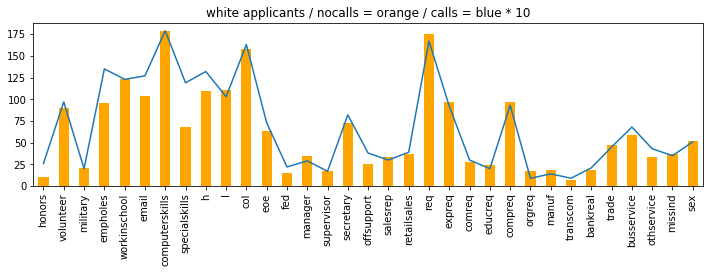

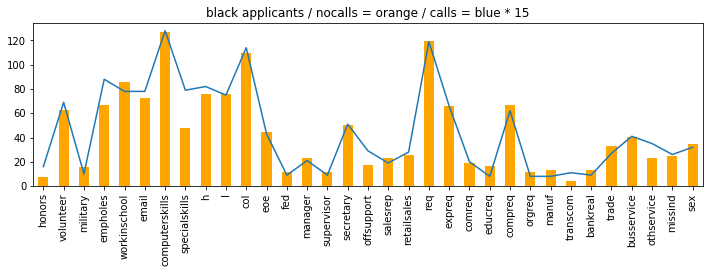

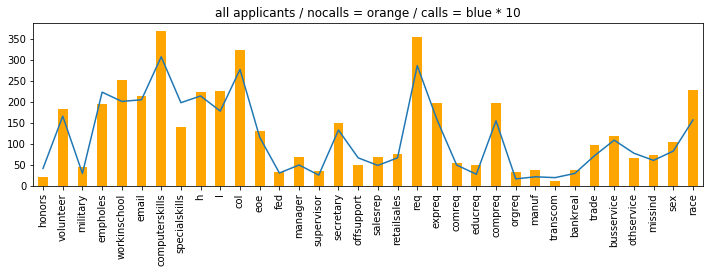

In [5]:
white_call_factors = calls_to_nocalls('white')
black_call_factors = calls_to_nocalls('black')
all_call_factors = calls_to_nocalls('all')

In [6]:
call_factors = pd.merge(white_call_factors.sums.to_frame(), black_call_factors.sums.to_frame(),\
                        left_index=True, right_index=True)
call_factors.rename(columns={'sums_x':'white_call_numbers', 'sums_y':'black_call_numbers'}, inplace=True)

ct = call_factors.T
ct['row_sums'] = ct.sum(axis=1)
obs_total = 3749 # just cheating a little bit to avoid doing two loops
for f in ct:
    ct.set_value('col_sums', f, ct[f].sum(axis=0))
    rx = (ct.loc['white_call_numbers']['row_sums'] * ct.loc['col_sums'][f])/obs_total
    ry = (ct.loc['black_call_numbers']['row_sums'] * ct.loc['col_sums'][f])/obs_total
    ct.set_value('white_call_numbers', f, rx)
    ct.set_value('black_call_numbers', f, ry)


ct.drop('row_sums', axis=1, inplace=True)
ct.drop('col_sums', axis=0, inplace=True)

def block1():
    (cs, pval, df, expected) = stats.chi2_contingency(observed=ct)
    print '\n', 'chi stat = ', cs, '| degrees of freedom = ', df, '|  pval = ', pval

<div class="span5 alert alert-info", style="background-color:PapayaWhip"> <b> Testing Independence </b> </div>

<div class="span5 alert alert-info", style="background-color:PapayaWhip">
Chi Square can be used to test the independence of variables.  That test, below, shows that the callback numbers as a function of individual qualification values are not dependent on race, which could also be seen in the plots above.
<p><br>
It's a little tricky to interpret (-- and I'm honestly not sure if I'm doing it right --).  For one thing, in this case the null hypothesis is that there _is_ an effect and the high p-value causes us to reject it.  What it means is that it's _not_ true the that ratio of calls between racial groups for a given qualification is significantly different from that ratio for another qualification.  Again, it merely confirms what we've already seen, that those ratios are roughly 10/1 for white applicants and 15/1 for black applicants across the range of qualifications. 
<br><br>
A suspiciously perfect P value either means that the study is incredibly well constructed or that I'm doing something wrong in the calculation.
</div>

In [7]:
block1()
ct


chi stat =  2.16807128926e-29 | degrees of freedom =  32 |  pval =  1.0


,honors,volunteer,military,empholes,workinschool,email,computerskills,specialskills,h,l,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,sex
white_call_numbers,25.217925,99.670846,18.012803,133.895172,120.685783,123.08749,184.331022,118.884503,128.491331,106.875967,...,93.066151,10.207255,13.209389,12.008536,18.012803,43.230728,65.446519,46.833289,36.626034,49.835423
black_call_numbers,16.782075,66.329154,11.987197,89.104828,80.314217,81.91251,122.668978,79.115497,85.508669,71.124033,...,61.933849,6.792745,8.790611,7.991464,11.987197,28.769272,43.553481,31.166711,24.373966,33.164577


In [8]:
# qualifications
wa  = data[dichotomized][data.race == 0]
wa['numquals']= wa.sum(axis=1)

ba = data[dichotomized][data.race == 1]
ba['numquals'] = ba.sum(axis=1)

sums = pd.merge(wa.numquals.value_counts().to_frame(), ba.numquals.value_counts().to_frame(), \
                left_index=True, right_index=True)
sums.rename(columns={'numquals_x':'wa', 'numquals_y':'ba'}, inplace=True)

sums['wcalls'] = np.nan
sums['bcalls'] = np.nan
for i in sums.index:
    sums.set_value(i, 'wcalls', wa.call[(wa.numquals == i) & (wa.call == 1)].sum())
    sums.set_value(i, 'bcalls', ba.call[(ba.numquals == i) & (ba.call == 1)].sum())

def fig1():
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    sums[['wa', 'ba']].sort_index().plot(ax=axs[0], \
                        title='# of white and black applicants by # qualifications')

    sums[['wcalls', 'bcalls']].sort_index().plot(ax=axs[1], \
                        title='# of calls for white and black applicants by # qualifications');
    axs[0].axvline(wa.numquals.mean())
    axs[0].axvline(ba.numquals.mean(), color='orange')
    axs[1].axvline(sum((sums.index * sums.wcalls))/sum(sums.wcalls))
    axs[1].axvline(sum((sums.index * sums.bcalls))/sum(sums.bcalls), color='orange')

<div class="span5 alert alert-info", style="background-color:PapayaWhip"> <b> Finding something normal to look at, despite the categorical data </b> </div>

<div class="span5 alert alert-info", style="background-color:PapayaWhip">
The two plots below show the number of qualifications of applicants and the number of calls they recieved for a given number of qualifications.  Both are roughly normal.  That might mean that the the kinds of jobs applied for in this study are mid-level jobs for which it is possible to be either under or over-qualified.  It might also mean that different kinds of qualifications appeal to different employers. 
<p><br>
Black applicants had a higher mean level of qualifications and they also had a higher mean level of qualifications/call. In other words, they got fewer calls overall for a given level of qualifications.  However, they did get more calls than white applicants at the level of 14 and 15 qualifications.  Whatever the reasons for that might be, the effect disappears again at the level of 16 qualifications.
<hr>
<ul>
<li> only categorical columns are plotted
<li> I don't know what most of the columns stand for, so my assumption that a 1 value is a positive statement may not be correct
</ul>
</div>

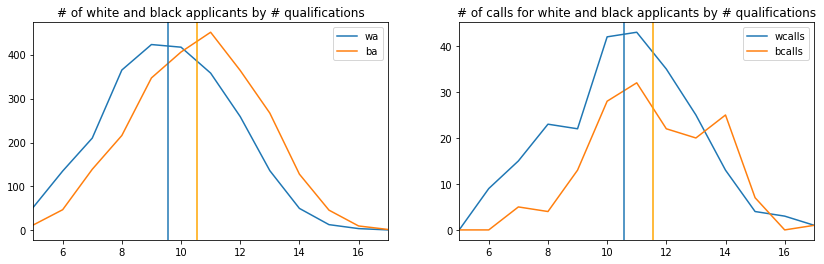

In [9]:
fig1()

In [10]:
# running chi squared on call numbers across the whole range of qualification levels (sums of qualifications)
callsums = sums.copy()
callsums.drop('wa', axis=1, inplace=True) # only need callcounts, not applicant counts
callsums.drop('ba', axis=1, inplace=True) # only need callcounts, not applicant counts
callsums.drop(5, axis=0, inplace=True)    # zero calls in both groups at this qualifacation level
observed = callsums.bcalls
expected = callsums.wcalls

def block2():
    # does ((observed - expected)**2/expected).sum()
    cx = stats.chisquare(f_obs=observed, f_exp= expected);
    print "Chi Square for the number of callbacks considering all qualification levels together"
    print '     chi square statistic = ', cx[0], '|  degrees of freedom = ', 32, '|  P value = ', cx[1]
    crit = stats.chi2.ppf(q = 0.95, df = 32)
    print '           critical value = ', crit, '\n'

    # running chi squared on just the number of calls by race
    simple_observed = len(ba[ba.call == 1])
    simple_expected = len(wa[wa.call == 1])
    cx = stats.chisquare(f_obs=simple_observed, f_exp=simple_expected);
    print "Chi Square for the number of callbacks by race alone"
    print '     chi square statistic = ', cx[0], '|  degrees of freedom = ', 1, ' |  P value < .001'
    crit = stats.chi2.ppf(q = 0.95, df = 1)
    print '           critical value = ', crit, '\n'

<div class="span5 alert alert-info", style="background-color:PapayaWhip"> <b> Conclusion </b> </div>

<div class="span5 alert alert-info", style="background-color:PapayaWhip">
The study is well constructed, with both pools of applicants being of equal size and having roughly the same distribution of qualifications.  When comparing callbacks for black and white populations using Chi Square, a P value of below .001 for all the qualification factors considered together as well as for the gross number of calls alone make it very clear that the the null hypothesis, which is that race is not a factor in these outcomes, is false.
<p><br>
Nevertheless, it's clear from the plots just above that the number of qualifications an applicant has is more of a factor in getting callsbacks than race.  That is, being white might lead to a 30% increase in calls, but having 11 qualifications vs 6 leads to a 400% increase in calls for whites and a 300% increase for blacks.  
</div>

In [11]:
block2()

Chi Square for the number of callbacks considering all qualification levels together
     chi square statistic =  64.6802516829 |  degrees of freedom =  32 |  P value =  1.23761080499e-09
           critical value =  46.1942595203 

Chi Square for the number of callbacks by race alone
     chi square statistic =  25.8893617021 |  degrees of freedom =  1  |  P value < .001
           critical value =  3.84145882069 

